In [7]:
%load_ext autoreload
%autoreload 2
from dolfinx import fem, mesh, plot
from dolfinx.io import gmshio
from mpi4py import MPI
import ufl
from petsc4py import PETSc
from slepc4py import SLEPc
import numpy as np
from dolfinx.io import XDMFFile
import matplotlib.pyplot as plt
from scipy.linalg import null_space
from dolfinx_utils import *
from helmholtz_x.passive_flame_x import *
from helmholtz_x.eigensolvers_x import pep_solver, eps_solver
from helmholtz_x.eigenvectors_x import normalize_eigenvector, normalize_unit, normalize_adjoint
from helmholtz_x.dolfinx_utils import XDMFReader, xdmf_writer 
from helmholtz_x.shape_derivatives_x import _shape_gradient_Robin
from helmholtz_x.shape_derivatives import ShapeDerivatives
from helmholtz_x.petsc4py_utils import conjugate_function

%autoreload utils.dolfin_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def normalize_robin_vectors(omega, A, B, C, p, p_adj, R, c, msh):
    # L_dash = omega*B + (2*omega)*C
    L_dash = (2*omega)*C
    V = fem.FunctionSpace(msh, ("Lagrange", 1))
    Lp = fem.Function(V)
    L_dash.mult(p.vector, Lp.vector)

    first_term_val = conjugate_function(p_adj).vector.dot(Lp.vector)
    print(first_term_val)

    # first_term = fem.form(ufl.inner(p_adj, Lp)*ufl.dx)
    # first_term_val = fem.assemble_scalar(first_term)

    Z = (1+R)/(1-R)
    Z=1
    second_term = fem.form((1j*c/Z) * ufl.inner(p_adj, p)*ufl.ds)
    second_term_val = fem.assemble_scalar(second_term)

    norm_const = first_term_val + second_term_val

    p.vector[:] = p.vector[:]/np.sqrt(norm_const)
    p_adj.vector[:] = p_adj.vector[:]/np.sqrt(norm_const)

    # print(norm_const)
    return [p, p_adj]

In [24]:
def find_eigenvalue(epsilon):
    N = 30
    degree = 1
    c_const = np.sqrt(5)
    R = -0.975-0.05j
    msh = mesh.create_box(MPI.COMM_WORLD, [[0, 0, -epsilon], [1, 1, 1]], [N, N, N])
    c = fem.Constant(msh, PETSc.ScalarType(c_const))

    boundaries = [(1, lambda x: np.isclose(x[0], 0)),
              (2, lambda x: np.isclose(x[0], 1)),
              (3, lambda x: np.isclose(x[2], -epsilon)),
              (4, lambda x: np.isclose(x[2], 1)),
              (5, lambda x: np.isclose(x[1], 0)),
              (6, lambda x: np.isclose(x[1], 1))]
    
    ds, facet_tags = tag_boundaries(msh, boundaries=boundaries, return_tags=True)

    boundary_conditions = {6: {'Robin': -0.99999},
                        5: {'Robin': -0.99999},
                        4: {'Robin': -0.99999},
                        3: {'Robin': R},
                        2: {'Robin': -0.99999},
                        1: {'Robin': -0.99999}}

    matrices = PassiveFlame(msh, facet_tags, boundary_conditions, c , degree = degree)

    matrices.assemble_A()
    matrices.assemble_B()
    matrices.assemble_C()

    A = matrices.A
    B = matrices.B
    C = matrices.C

    target =  np.pi*c_const/2
    E = pep_solver(A, B, C, target**2, nev = 2)
    omega, p = normalize_eigenvector(msh, E, 0, degree=degree, which='right')
    omega_adj, p_adj = normalize_eigenvector(msh, E, 0, degree=degree, which='left')

    assert np.isclose(omega, omega_adj)


    p = normalize_magnitude(p)
    p_adj = normalize_magnitude(p_adj)
    
    normalize_robin_vectors(omega, A, B, C, p, p_adj, R, c, msh)

    return [omega, p, p_adj, msh, ds, c, facet_tags]

In [10]:
def find_shapegrad_dirichlet(geometry, omega, p, p_adj, ds, c):
    # dp_dn = ufl.Dn(p)
    # G = _shape_gradient_Robin(geometry, c, omega, p, conjugate_function(p_adj), 3)

    p_adj = conjugate_function(p_adj)
    G = - p_adj * (c*ufl.Dn(c))*ufl.Dn(p) + ufl.div(p_adj*(c**2)*ufl.grad(p)) - 2*ufl.Dn(p_adj)*(c**2)*ufl.Dn(p)
    
    # shape_der = ShapeDerivatives(geometry, [], p, p_adj, c)
    # shape_der.curvature = 0
    # G = shape_der.get_Robin()

    C = 1
    dw = fem.assemble_scalar(fem.form(C* G*ds(3)))

    return dw

In [11]:
class Geometry:
    def __init__(self, msh, facet_tags):
        self.mesh = msh
        self.facet_tags = facet_tags
    
    def get_curvature_field(self, index):
        return 0

\/ Speed of sound function is used for passive flame matrices.
- Passive matrices are assembling..
- Matrix A is assembled.
- Matrix B is assembled.
- Matrix C is assembled.

- PEP solver started.
- PEP solver converged. Eigenvalue computed.
Eigenvalue-> 12.175865-0.008990j

Frequency -> 1.937849 (1/s) | Growth Rate -> -0.008990 (rad/s) 

Eigenvalue-> 12.175865-0.008990j

Frequency -> 1.937849 (1/s) | Growth Rate -> -0.008990 (rad/s) 

(3.0419284434096237+0.0022458999314445825j)
\/ Speed of sound function is used for passive flame matrices.
- Passive matrices are assembling..
- Matrix A is assembled.
- Matrix B is assembled.
- Matrix C is assembled.

- PEP solver started.
- PEP solver converged. Eigenvalue computed.
Eigenvalue-> 12.175865-0.008990j

Frequency -> 1.937849 (1/s) | Growth Rate -> -0.008990 (rad/s) 

Eigenvalue-> 12.175865-0.008990j

Frequency -> 1.937849 (1/s) | Growth Rate -> -0.008990 (rad/s) 

(3.0419284434096237+0.0022458999314445825j)
\/ Speed of sound function is us

Text(0, 0.5, '$|\\delta_{FD} - \\delta_{AD}|$')

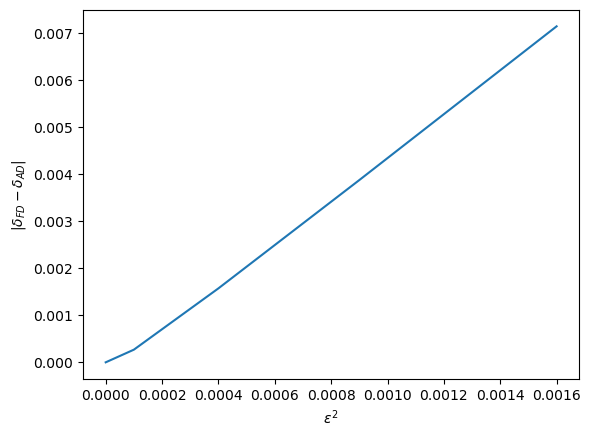

In [25]:
omega, p, p_adj, msh, ds, c, facet_tags = find_eigenvalue(0)
geometry = Geometry(msh, facet_tags)
dw = find_shapegrad_dirichlet(geometry, omega, p, p_adj, ds, c)

x_points = []
y_points = []

for i in range(5):
    epsilon = 0.01*i
    omega_new = find_eigenvalue(epsilon)[0]
    Delta_w_FD = omega_new.real - omega.real
    x_points.append(epsilon**2)
    y_points.append(abs(Delta_w_FD - dw*epsilon))

plt.plot(x_points, y_points)
plt.xlabel('$\epsilon^2$')
plt.ylabel('$|\delta_{FD} - \delta_{AD}|$')